In [1]:
from turc import TurcEstimator
import polars as pl

In [2]:
turc = TurcEstimator(
    caravan_path="/Users/nicolaslazaro/Desktop/QC_and_CLEAN_LSH_hive_data/train",
    basin_list_path="/Users/nicolaslazaro/Desktop/work/wb-project/model-training/configs/basin_ids_files/cluster2_natural_basins_filtered_holdout.txt",
    batch_size=100,
    use_pet=True
)

annual = turc.compute_annual()

annual.head(10)   

# Cast all negative Q_turc_mm to zero
annual = annual.with_columns(
    pl.when(pl.col("Q_turc_mm") < 0)
    .then(0)
    .otherwise(pl.col("Q_turc_mm"))
    .alias("Q_turc_mm")
)

annual.filter(pl.col("gauge_id") == "grdc_5202081")["annual_precip_mm"].mean()

297.0466176470588

In [3]:
len(annual["gauge_id"])

4448

In [4]:
# print(invalid_basins.to_series().to_list())

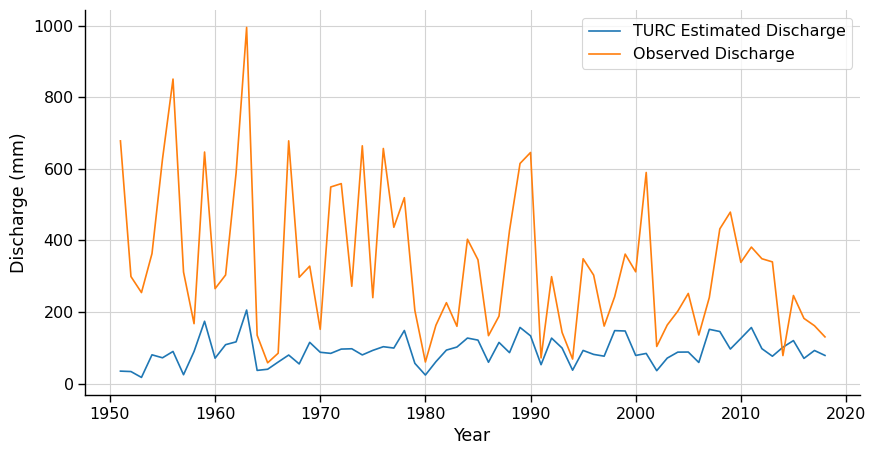

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("paper", font_scale=1.3)

# Random basin choice
basin_id = "grdc_5202081"
basin_data = annual.filter(pl.col("gauge_id") == basin_id)

plt.figure(figsize=(10, 5))
sns.lineplot(data=basin_data.to_pandas(), x='year', y='Q_turc_mm', label='TURC Estimated Discharge')
sns.lineplot(data=basin_data.to_pandas(), x='year', y='Q_observed_mm', label='Observed Discharge')
plt.xlabel('Year')
plt.ylabel('Discharge (mm)')
plt.legend()
plt.grid(color='lightgrey')
sns.despine()
plt.show()

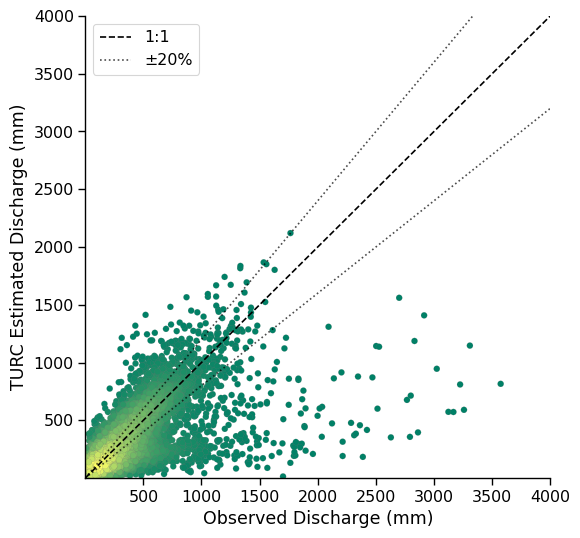

In [6]:
from scipy.stats import gaussian_kde
import numpy as np

xy = np.vstack([annual['Q_observed_mm'], annual['Q_turc_mm']])
mask = np.isfinite(xy).all(axis=0)
xy_filtered = xy[:, mask]

# Calculate density on filtered data
z = gaussian_kde(xy_filtered)(xy_filtered)

# Get max value for line plotting
max_val = annual.select(pl.col("Q_observed_mm").max()).item()

# Plot using filtered data
plt.figure(figsize=(6, 6))
plt.scatter(xy_filtered[0], xy_filtered[1],
        c=z, s=20, cmap='summer', alpha=1,
        edgecolors="#747474", linewidths=0.1)

# 1:1 line
plt.plot([0, max_val], [0, max_val],
        color='black', linestyle='--', label='1:1')

# +20% line
plt.plot([0, max_val], [0, max_val * 1.2],
        color='black', linestyle=':', alpha=0.7)

# -20% line  
plt.plot([0, max_val], [0, max_val * 0.8],
        color='black', linestyle=':', alpha=0.7, label='±20%')

plt.xlabel('Observed Discharge (mm)')
plt.ylabel('TURC Estimated Discharge (mm)')
plt.xlim(1, 4000)
plt.ylim(1, 4000)
plt.legend()
sns.despine()
plt.show()

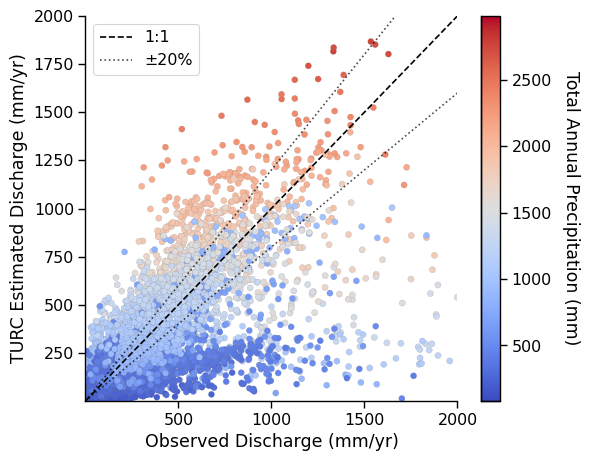

In [7]:
fig, ax = plt.subplots(figsize=(6, 5))

# Use scatter instead of sns.scatterplot for better colorbar control
scatter = ax.scatter(x=annual["Q_observed_mm"], y=annual["Q_turc_mm"], 
                     s=20, alpha=1, c=annual["annual_precip_mm"],
                     edgecolors="#747474", linewidths=0.1, cmap='coolwarm')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Total Annual Precipitation (mm)', rotation=270, labelpad=20)

# 1:1 line
ax.plot([0, max_val], [0, max_val],
        color='black', linestyle='--', label='1:1')

# +20% line
ax.plot([0, max_val], [0, max_val * 1.2],
        color='black', linestyle=':', alpha=0.7)

# -20% line  
ax.plot([0, max_val], [0, max_val * 0.8],
        color='black', linestyle=':', alpha=0.7, label='±20%')

ax.set_xlabel('Observed Discharge (mm/yr)')
ax.set_ylabel('TURC Estimated Discharge (mm/yr)')
ax.set_xlim(1, 2000)
ax.set_ylim(1, 2000)
ax.legend()
sns.despine()

plt.savefig("/Users/nicolaslazaro/Desktop/work/wb-project/turc/plots/turc_with_PET_estimated_vs_observed_annual_discharge_with_precipitation.png", dpi=300, bbox_inches='tight')
plt.show()

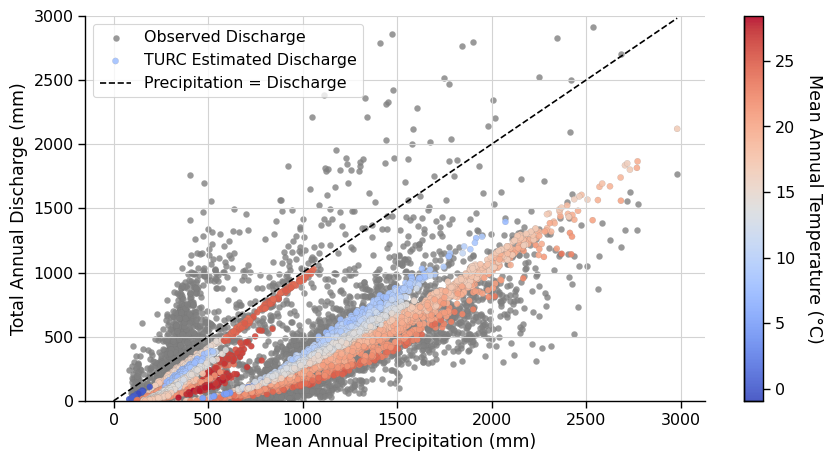

In [8]:
# Annual schema:
# Schema([('gauge_id', String),
#         ('year', Int64),
#         ('annual_precip_mm', Float64),
#         ('annual_temp_c', Float64),
#         ('L', Float64),
#         ('AET_turc_mm', Float64),
#         ('Q_turc_mm', Float64),
#         ('Q_observed_mm', Float64),
#         ('n_days', Int64),
#         ('n_valid_days', Int64)])

# Plot Q_turc_mm and Q_observed_mm on y axis against annual_precip_mm on x axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot observed discharge (no color mapping)
sns.scatterplot(data=annual.to_pandas(), x='annual_precip_mm', y='Q_observed_mm', 
                label='Observed Discharge', ax=ax, edgecolor="#747474", linewidth=0.1, s=20, color='gray', alpha=0.8)

# Plot TURC discharge with temperature color mapping
scatter = ax.scatter(annual.to_pandas()['annual_precip_mm'], 
                     annual.to_pandas()['Q_turc_mm'],
                     c=annual.to_pandas()['annual_temp_c'],
                     cmap='coolwarm',
                     label='TURC Estimated Discharge', 
                     edgecolor="#747474", 
                     linewidth=0.1, 
                     s=20, 
                     alpha=0.9)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Mean Annual Temperature (°C)', rotation=270, labelpad=20)

# Add 1:1 line
max_precip = annual.select(pl.col("annual_precip_mm").max()).item()
ax.plot([0, max_precip], [0, max_precip],
        color='black', linestyle='--', label='Precipitation = Discharge')

ax.set_xlabel('Mean Annual Precipitation (mm)')
ax.set_ylabel('Total Annual Discharge (mm)')
ax.legend()
ax.grid(color='lightgrey')
ax.set_ylim(0, 3000)
sns.despine()
plt.savefig("/Users/nicolaslazaro/Desktop/work/wb-project/turc/plots/turc_with_PET_estimated_and_observed_annual_discharge_vs_precipitation.png", dpi=300, bbox_inches='tight')
plt.show()


In [9]:
# 1. Calculate PBIAS
annual_analysis = annual.with_columns([
    ((pl.col("Q_turc_mm") - pl.col("Q_observed_mm")) / pl.col("Q_observed_mm") * 100).alias("pbias")
]).with_columns([
    pl.col("pbias").abs().alias("abs_pbias")
])

# 2. Analysis 1: Very dry years (P < 500mm), all temperatures
dry_years = annual_analysis.filter(pl.col("annual_precip_mm") < 500)

print("\n=== DRY YEARS (P < 500mm) ===")
print(f"n = {len(dry_years)} basin-years")
print(f"Median PBIAS: {dry_years['pbias'].median():.1f}%")
print(f"% within ±20%: {(dry_years['abs_pbias'] <= 20).mean() * 100:.1f}%")

# Analysis 2: Wet years (P > 1500mm)
wet_years = annual_analysis.filter(pl.col("annual_precip_mm") > 1500)

print("\n=== WET YEARS (P > 1500mm) ===")
print(f"n = {len(wet_years)} basin-years")
print(f"Median PBIAS: {wet_years['pbias'].median():.1f}%")
print(f"% within ±20%: {(wet_years['abs_pbias'] <= 20).mean() * 100:.1f}%")

# Analysis 3: Moderate precip years (500-1500mm), split by temperature
moderate_cold_years = annual_analysis.filter(
    (pl.col("annual_precip_mm") >= 500) & 
    (pl.col("annual_precip_mm") <= 1500) &
    (pl.col("annual_temp_c") < 20)
)

moderate_warm_years = annual_analysis.filter(
    (pl.col("annual_precip_mm") >= 500) & 
    (pl.col("annual_precip_mm") <= 1500) &
    (pl.col("annual_temp_c") >= 20)
)

print("\n=== MODERATE-COLD YEARS (500-1500mm, T < 20°C) ===")
print(f"n = {len(moderate_cold_years)} basin-years")
print(f"Median PBIAS: {moderate_cold_years['pbias'].median():.1f}%")
print(f"% within ±20%: {(moderate_cold_years['abs_pbias'] <= 20).mean() * 100:.1f}%")

print("\n=== MODERATE-WARM YEARS (500-1500mm, T >= 20°C) ===")
print(f"n = {len(moderate_warm_years)} basin-years")
print(f"Median PBIAS: {moderate_warm_years['pbias'].median():.1f}%")
print(f"% within ±20%: {(moderate_warm_years['abs_pbias'] <= 20).mean() * 100:.1f}%")


=== DRY YEARS (P < 500mm) ===
n = 1266 basin-years
Median PBIAS: -50.6%
% within ±20%: 13.0%

=== WET YEARS (P > 1500mm) ===
n = 766 basin-years
Median PBIAS: 17.8%
% within ±20%: 36.4%

=== MODERATE-COLD YEARS (500-1500mm, T < 20°C) ===
n = 1802 basin-years
Median PBIAS: 14.8%
% within ±20%: 32.6%

=== MODERATE-WARM YEARS (500-1500mm, T >= 20°C) ===
n = 614 basin-years
Median PBIAS: -21.9%
% within ±20%: 25.8%


In [10]:
# Print the percentage of years with Q_turc within ±20% of Q_observed
within_20pct = (annual_analysis['abs_pbias'] <= 20).mean()
print(f"\nOverall, {within_20pct * 100:.1f}% of years have Q_turc within ±20% of Q_observed.")  

basin_stats = (annual_analysis
    .group_by("gauge_id")
    .agg([
        pl.col("annual_precip_mm").min().alias("min_precip_mm"),
        pl.col("annual_precip_mm").max().alias("max_precip_mm"),
        (pl.col("abs_pbias") <= 20).mean().alias("pct_years_within_20pct")
    ])
    .filter(pl.col("pct_years_within_20pct") >= 0.5)
)

print(f"\nNumber of basins with ≥50% of years within ±20% PBIAS: {basin_stats.height}")
print(f"Precipitation range of these basins: {basin_stats.select(pl.col('min_precip_mm').min()).item():.1f} mm to {basin_stats.select(pl.col('max_precip_mm').max()).item():.1f} mm")
print(f"Temperature range of these basins: {annual_analysis.join(basin_stats, on='gauge_id').select(pl.col('annual_temp_c').min()).item():.1f} °C to {annual_analysis.join(basin_stats, on='gauge_id').select(pl.col('annual_temp_c').max()).item():.1f} °C")

# In that T and be range, which proportion of all basin in that range have ≥50% of years within ±20% PBIAS, 




Overall, 26.7% of years have Q_turc within ±20% of Q_observed.

Number of basins with ≥50% of years within ±20% PBIAS: 19
Precipitation range of these basins: 712.6 mm to 2982.3 mm
Temperature range of these basins: 7.2 °C to 25.3 °C


In [11]:
# Define the climate ranges from the "good" basins
p_min, p_max = 712.6, 2982.3
t_min, t_max = 7.2, 25.3

# Count all basins within those climate ranges
basins_in_range = (annual_analysis
    .group_by("gauge_id")
    .agg([
        pl.col("annual_precip_mm").min().alias("min_precip"),
        pl.col("annual_precip_mm").max().alias("max_precip"),
        pl.col("annual_temp_c").min().alias("min_temp"),
        pl.col("annual_temp_c").max().alias("max_temp")
    ])
    .filter(
        (pl.col("min_precip") >= p_min) & 
        (pl.col("max_precip") <= p_max) &
        (pl.col("min_temp") >= t_min) & 
        (pl.col("max_temp") <= t_max)
    )
)

total_basins_in_range = basins_in_range.height
proportion = 19 / total_basins_in_range if total_basins_in_range > 0 else 0

print(f"Total basins within P=[{p_min:.1f}, {p_max:.1f}] mm and T=[{t_min:.1f}, {t_max:.1f}] °C: {total_basins_in_range}")
print(f"Basins with ≥50% years within ±20% PBIAS: 19")
print(f"Proportion: {proportion:.1%} ({19}/{total_basins_in_range})")

Total basins within P=[712.6, 2982.3] mm and T=[7.2, 25.3] °C: 52
Basins with ≥50% years within ±20% PBIAS: 19
Proportion: 36.5% (19/52)
